In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
sys.path.append('../train/')
from preproc_6ax_data import load_and_preproc_data_single, resample_df
import seaborn as sns
import glob
import numpy as np
sns.set()
sns.set_style('whitegrid')
model_predict = True
import imageio

In [7]:
if model_predict:
    from train import build_net, load_data, train_model, reshape_function, build_cnn
    !pip install -q tensorflow==2.3.0
    import tensorflow as tf

You should consider upgrading via the '/home/asya/anaconda3/envs/tflite/bin/python -m pip install --upgrade pip' command.


In [8]:
filename_silks = '/home/asya/Desktop/Gyro_Data/bluepy_data/testdata_preproc/1106_ctrl_test_seq1_preproc.txt'
df, b1_press_t, b2_press_t = load_and_preproc_data_single(filename_silks)
df = resample_df(df.reset_index(), 'linear', 119.)

In [16]:
def reshape_function(data, label):
    reshaped_data = tf.reshape(data, [-1, 6, 1])
    return reshaped_data, label

def pad_predictions(predictions, seq_length):
    return np.vstack((np.zeros((seq_length,4)),np.asarray(predictions)))

def predict_from_df(df, model, seq_length):
    data = df[['ax','ay','az','gx','gy','gz']].values
    data_batch = []
    labels = []
    for i in range(len(data)-seq_length):
        data_batch.append(data[i:(seq_length+i)])
        labels.append(-1)
    batch_size = 64
    dataset = tf.data.Dataset.from_tensor_slices((data_batch, np.asarray(labels).astype("int32")))
    dataset = dataset.map(reshape_function).batch(batch_size)
    predictions = model.predict(dataset)
    return pad_predictions(predictions, seq_length)

In [17]:
class video_reader:
    def __init__(self, filename_vid, synchframe, filename_silks, model_predict = False):
        self.cap = cv2.VideoCapture(filename_vid)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.synchframe = synchframe
        self.frame_width = int(self.cap.get(3))
        self.frame_height = int(self.cap.get(4))
        
        ## read in the intertial sensor data
        df, b1_press_t, b2_press_t = load_and_preproc_data_single(filename_silks)
        buttons_t = sorted(list(b1_press_t) + list(b2_press_t))
        
        ## filter the values after buttons_t button press (synchronization cue)
        df = df.loc[df.index > buttons_t[0]]
        df.index = df.index - buttons_t[0]
        buttons_t = [a-buttons_t[0] for a in buttons_t]
        
        self.buttons_t = buttons_t
        self.t_vid = np.arange(0, df.index[-1], 1/self.get_fps())
        self.df = df
                
    
    
    def make_model_predictions(self):
        model, model_path = build_cnn(60)
        model.load_weights('../train/{}/weights.h5'.format(model_path))
        
        df = self.df
        df.reset_index(inplace = True)
        
        if not 'p_select' in df:
            df = resample_df(df, 'linear', 119.)
        else:
            df.drop(['p0','p1','p2','p3'], axis = 1, inplace = True)
            
        predictions = predict_from_df(df,model, 60)
        df = pd.concat((df.reset_index(), pd.DataFrame(predictions, columns = ['p0','p1','p2','p3'])), axis = 1)
        df['p_select'] = np.argmax(predictions, axis=1)
        df['p_color'] = df['p_select'].apply(lambda x: sns.color_palette("tab10", 10)[x if x<2 else 2*x])
        df.set_index('t', inplace = True)
        self.df = df
    
    def get_width(self):
        return self.frame_width
    def get_height(self):
        return self.frame_height
    def get_fps(self):
        return self.fps
    def get_buttons_t(self):
        return self.buttons_t
    
    def read_frames(self, init_frame, N_frames, limit_field = False):
        self.cap.set(1,init_frame+self.synchframe)
        
        frames = []
        j = 0
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            j+=1
            if j > N_frames: break
            if limit_field:
                frames.append(frame[0:800,550:1250,:])
            else:
                frames.append(frame)
        cv2.destroyAllWindows()
        return frames
    
    def read_data_timerange(self, init_time, N_frames):
        init_frame = np.where(self.t_vid > init_time)[0][0]
        max_time = init_time+N_frames/(self.get_fps())

        frames = self.read_frames(init_frame, N_frames)        
        df_clip = self.df.query('t > {} and t <{}'.format(init_time, max_time))
        df_clip.index = df_clip.index - df_clip.index[0]
        return frames, df_clip

In [18]:
filename_silks = '/home/asya/Desktop/Gyro_Data/bluepy_data/testdata_preproc/1106_ctrl_test_seq1_preproc.txt'
VR = video_reader('/home/asya/Videos/silks/1106_testseq1.mp4', 480, filename_silks, model_predict)
VR.make_model_predictions()
t_buttons = VR.get_buttons_t()

model CNN
Built CNN.


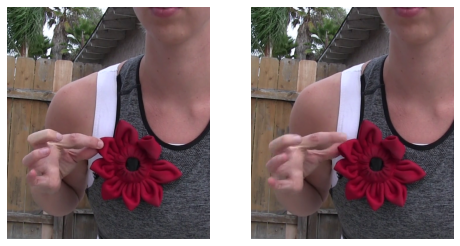

In [19]:
## demo initial button press frame
frames = VR.read_frames(0, 2, True)
fig, ax = plt.subplots(1,2, figsize = (8,7))
i = 0
ax[0].imshow(frames[i]);i = i+1; ax[0].axis('off')
ax[1].imshow(frames[i]);i = i+1; ax[1].axis('off')
fig.savefig('init_frame_save.png')

In [20]:
import matplotlib as mpl

def makeframe(fig, frame, df_clip, t_i):
    gs = fig.add_gridspec(6,2)
    ax_v = fig.add_subplot(gs[:-2, :])
    ax_g = fig.add_subplot(gs[-2,:])
    ax_g.set_title('Gyroscope')
    ax_a = fig.add_subplot(gs[-1,:], sharex = ax_g)
    ax_a.set_title('Accel')
    
    ax_v.imshow(frame); ax_v.axis('off')

    df_clip.gx.plot(ax = ax_g, legend = 'gx')
    df_clip.gy.plot(ax = ax_g, legend = 'gy')
    df_clip.gz.plot(ax = ax_g, legend = 'gz')

    ax_g.plot([t_i,t_i],[-10,350],color = 'k')
    ax_g.set_ylabel('dps')
    ax_g.get_xaxis().set_visible(False)

    df_clip.ax.plot(ax =ax_a, legend = 'ax')
    df_clip.ay.plot(ax =ax_a, legend = 'ay')
    df_clip.az.plot(ax =ax_a, legend = 'az')
    ax_a.plot([t_i,t_i],[-3.5,1],color = 'k')

    tmax = np.floor(df_clip.index.max())
    ymin = -3.5
    ax_a.plot([tmax-1,tmax],[ymin,ymin],color = 'k')
    ax_a.text(tmax-.5, ymin-.5, '1 s', fontsize=10,
            verticalalignment='top')

    ax_a.set_ylabel('g')
    ax_a.get_xaxis().set_visible(False)
    
def makeframe_preds(fig, frame, df_clip, t_i):
    gs = fig.add_gridspec(7,2)
    ax_v = fig.add_subplot(gs[:-3, :])
    ax_p = fig.add_subplot(gs[-3,:])
    ax_p.set_title('Prediction')
    
    ax_g = fig.add_subplot(gs[-2,:], sharex = ax_p)
    ax_g.set_title('Gyroscope')
    ax_a = fig.add_subplot(gs[-1,:], sharex = ax_p)
    ax_a.set_title('Accel')
    
    ax_v.imshow(frame); ax_v.axis('off')

    df_clip[['p0','p1','p2','p3']].rename({'p0':'ground','p1':'silks','p2':'salto A', 'p3':'salto B'}, axis = 1).plot(ax = ax_p)
    current_color = df_clip.query('t > {} and t <{}'.format(t_i-0.02, t_i+0.001)).p_color.value_counts().index[0]
    ax_p.plot([t_i,t_i],[0,1],color = current_color)
    
    df_clip.gx.plot(ax = ax_g, legend = 'gx')
    df_clip.gy.plot(ax = ax_g, legend = 'gy')
    df_clip.gz.plot(ax = ax_g, legend = 'gz')

    ax_g.plot([t_i,t_i],[-10,350],color = 'k')
    ax_g.set_ylabel('dps')
    ax_g.get_xaxis().set_visible(False)

    df_clip.ax.plot(ax =ax_a, legend = 'ax')
    df_clip.ay.plot(ax =ax_a, legend = 'ay')
    df_clip.az.plot(ax =ax_a, legend = 'az')
    ax_a.plot([t_i,t_i],[-3.5,1],color = 'k')

    tmax = np.floor(df_clip.index.max())
    ymin = -3.5
    ax_a.plot([tmax-1,tmax],[ymin,ymin],color = 'k')
    ax_a.text(tmax-.5, ymin-.5, '1 s', fontsize=10,
            verticalalignment='top')

    ax_a.set_ylabel('g')
    ax_a.get_xaxis().set_visible(False)

In [21]:
def save_fig(fle_out, t_button):
    frames, df_clip = VR.read_data_timerange(t_button, 120)
    
    fig = plt.figure(figsize = (6,8), constrained_layout=True, dpi = 200)

    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['axes.edgecolor'] = 'w'
    mpl.rcParams['axes.grid'] = True


    with imageio.get_writer(fle_out, mode='I') as writer:
        for i in range(len(frames)):
            t_i = i/VR.get_fps()
            if model_predict:
                makeframe_preds(fig, frames[i], df_clip, t_i)
            else:
                makeframe(fig, frames[i], df_clip, t_i)
            fig.savefig('foo.png')
            image = imageio.imread('foo.png')
            writer.append_data(image)
            plt.clf()

In [22]:
for t_select in range(len(t_buttons)):
    save_fig('./ctrl_preds_v1{}.gif'.format(t_select), t_buttons[t_select])

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

In [116]:
save_fig('./ctrl_preds{}.gif'.format(4), t_buttons[4])

<Figure size 1200x1600 with 0 Axes>

In [97]:
VR.df

,ax,ay,az,gx,gy,gz,button1,button2,p0,p1,p2,p3,p_select,p_color
t,,,,,,,,,,,,,,
0.003538,0.985859,-0.128538,-0.031105,0.675401,0.697021,0.621620,0.0,1.0,0.998337,0.001663,5.777714e-12,2.191886e-08,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
0.011941,0.994627,-0.135582,-0.025314,2.288235,2.894118,1.310458,0.0,1.0,0.998687,0.001313,3.099856e-12,1.448504e-08,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
0.020345,0.999966,-0.131862,-0.028402,3.900000,3.693109,1.398852,0.0,1.0,0.998937,0.001063,8.947654e-12,3.619002e-08,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
0.028748,0.999125,-0.128501,-0.038206,3.900000,3.525042,1.370840,0.0,1.0,0.998919,0.001081,1.008789e-11,3.941572e-08,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
0.037151,0.998285,-0.125139,-0.048010,3.900000,3.356975,1.342829,0.0,1.0,0.998919,0.001081,1.008789e-11,3.941572e-08,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86.121185,0.793876,-0.142221,0.523230,3.145151,1.955757,1.310606,0.0,0.0,0.990161,0.009839,1.248931e-10,1.595887e-07,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
86.129588,0.796828,-0.142448,0.521413,2.986169,1.910334,1.424165,0.0,0.0,0.992170,0.007830,1.107818e-10,1.601548e-07,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
86.137992,0.799781,-0.142675,0.519596,2.827186,1.864910,1.537724,0.0,0.0,0.994548,0.005452,4.712518e-11,8.912542e-08,0,"(0.12156862745098039, 0.4666666666666667, 0.70..."
